# A5

In [1]:
# Standard Imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import Network as NN
import importlib
import mnist_loader

import copy
import random

# Q1: Electrophysiology Experiment

In [2]:
import lif

def MonkeyFixationSpikes(x, T, pop):
    """
    spike_times = MonkeyFixationSpikes(x, T, pop)

    Given the gaze direction, outputs the spiking activity of the monkey's
    neurons.

    Input:
      x is the monkey's gaze direction
      T is the duration of the fixation (in seconds)
      pop is a 6xN matrix of LIF parameters

    Output:
      spike_times is an list containing N arrays of time-stamps indicating
        when each neuron fired.  
    """
    dt = 0.001  # time-step size for simulations
    xts = x*np.ones(int(T/dt))
    sp, v = lif.Stim2Spikes(xts, dt, pop, interp=True)
    return sp

In [3]:
#=====================
# CHOOSE A MONKEY
# The monkey's are numbered 0, 1, 2, 3, and 4.
# This will read in the LIF parameters for the monkey's neurons
# as well as the spiking trains for the unknown sequence.
#=====================
infile = open('monkey3.npz', 'rb')
varsin = np.load(infile)
pop = varsin['pop']   # parameters for population of neurons
Asp = varsin['Asp']   # spike trains for unknown sequence
N = len(pop[1])  # number of neurons

## (a) Behavioural Sampling Experiment

In [4]:
# ***** YOUR CODE HERE *****
# i. Select a spread of stimulus values from 0 to 9. Choose at least 100 samples.
n_samples = 100
#X = sorted(np.random.uniform(-1, 10, n_samples))
X = np.linspace(0, 9, n_samples)


In [5]:
%%capture
'''
# ii. Fix the monkey's gaze on each chosen direction for 0.4 seconds. Record the corresponding spikes.
T = 0.4 # duration of fixation
A = np.zeros((n_samples, N)) # 100 x 40

for j, x in enumerate(X):
    st = np.array(MonkeyFixationSpikes(X[j], T, pop))
    spikes_count = np.array([len(st[i]) for i in range(N)])
    firing_rate = spikes_count / T
    A[j][:] = firing_rate
'''

In [6]:
# ii. Fix the monkey's gaze on each chosen direction for 0.4 seconds. Record the corresponding spikes.
T = 0.4 # duration of fixation
A = np.zeros((n_samples, N)) # 100 x 40
A = lif.Stim2Rate(X, pop)

## (b) View Tuning Curves

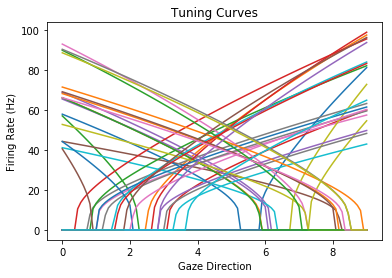

In [7]:
# ***** YOUR CODE HERE *****
for i in range(N):
    firing_rate= A.T[i]
    plt.plot(X, firing_rate)
    plt.title('Tuning Curves')
    plt.xlabel('Gaze Direction')
    plt.ylabel('Firing Rate (Hz)')
    

## (c) Compute the Decoding Weights

In [8]:
# ***** YOUR CODE HERE *****
D = np.linalg.inv(A.T @ A) @ A.T @ X

## (d) View Spike Raster of Unknown Sequence

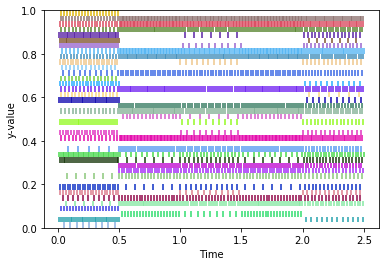

In [9]:
# ***** YOUR CODE HERE *****
plt.figure()
lif.PlotSpikeRaster(Asp)
plt.xlabel('Time')
plt.ylabel('y-value')
plt.show()

## (e) Decode the Unknown Code

In [10]:
# Spike trains for unknown sequence are stored in 'Asp'
# Asp is a list of arrays of spike trains, one array per neuron.


In [11]:
# Compute firing rates
# Decode unknown code
# ***** YOUR CODE HERE *****
gaze_directions = []
for i in range(5):
    t_start = 0.5 * i
    t_end = t_start + 0.5
    counts = lif.CountSpikes(Asp, t_start, t_end)
    rate = counts / 0.5
    direction = rate @ D
    gaze_directions.append(direction)


## (f) Display the Unknown Code

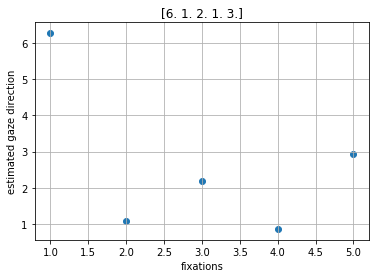

In [12]:
# ***** YOUR CODE HERE *****
rounded_directions = np.round(np.array(gaze_directions))

plt.figure()
plt.title(str(rounded_directions))
x = [1, 2, 3, 4, 5]
plt.scatter(x, gaze_directions)
plt.xlabel('fixations')
plt.ylabel('estimated gaze direction')
plt.grid(True)
plt.show()

# Q2: LSTM

In [13]:
# You may include some Python code to help you.
# intial states
h0 = 0.05
C0 = -0.02

# weights for the forget gate
Wf = np.array([0, 8, 0, 0])
bf = -4

# weights for the input gate
Wi = np.array([0, 0, 9, 0])
bi = -4.5

# weights for the output gate
Wo = np.array([0, 0, 0, 10])
bo = -5

# weights for the cell gate
Wc = np.array([1, 0, 0, 0])
bc = 0

## (a)

In [14]:
# You can include some code, if you want.
xs = [[1, 0, 0], [0, 1, 0], [1, 0, 1]]
fts = []
its = []
ots = []
Cs = []
hs = []

for x in xs:
    # aggregate the input
    vt = np.vstack((h0, np.array(x).reshape(-1, 1)))
    
    # compute gate values
    ft = NN.Logistic(Wf @ vt + bf)
    it = NN.Logistic(Wi @ vt + bi)
    ot = NN.Logistic(Wo @ vt + bo)
    fts.append(ft)
    its.append(it)
    ots.append(ot)
    
    # compute input cell state values
    C_t = NN.Tanh(Wc @ vt + bc)
    Ct = ft * C0 + it * C_t
    ht = ot * NN.Tanh(Ct)
    Cs.append(Ct)
    hs.append(ht)
    
    # print the parameter and output values for each input value
    print("For input value x = " + str(x) + ":")
    print("Intial states: C0 = %f, h0 = %f" % (C0, h0))
    print("(ft, it, ot) = (%f, %f, %f) " % (ft, it, ot))
    print("Ct = %f ht = %f" % (Ct, ht) + '\n')


For input value x = [1, 0, 0]:
Intial states: C0 = -0.020000, h0 = 0.050000
(ft, it, ot) = (0.982014, 0.010987, 0.006693) 
Ct = -0.019091 ht = -0.000128

For input value x = [0, 1, 0]:
Intial states: C0 = -0.020000, h0 = 0.050000
(ft, it, ot) = (0.017986, 0.989013, 0.006693) 
Ct = 0.049050 ht = 0.000328

For input value x = [1, 0, 1]:
Intial states: C0 = -0.020000, h0 = 0.050000
(ft, it, ot) = (0.982014, 0.010987, 0.993307) 
Ct = -0.019091 ht = -0.018961



### (i)

See above.

### (ii)

See above.

### (iii)

See above.

## (b)

In [15]:
# Ct = Ct-1 + ht-1
xt = [1, 1, 0]

# aggregate the input
vt = np.vstack((h0, np.array(xt).reshape(-1, 1)))

# compute gate values
ft = NN.Logistic(Wf @ vt + bf)
it = NN.Logistic(Wi @ vt + bi)
ot = NN.Logistic(Wo @ vt + bo)

# compute input cell state values
C_t = NN.Tanh(Wc @ vt + bc)
Ct = ft * C0 + it * C_t
ht = ot * NN.Tanh(Ct)

# print the parameter and output values for each input value
print("For input value x = " + str(xt) + ":")
print("Intial states: C0 = %f, h0 = %f" % (C0, h0))
print("(ft, it, ot) = (%f, %f, %f) " % (ft, it, ot))
print("Ct = %f, ht = %f" % (Ct, ht) + '\n')


For input value x = [1, 1, 0]:
Intial states: C0 = -0.020000, h0 = 0.050000
(ft, it, ot) = (0.982014, 0.989013, 0.006693) 
Ct = 0.029769, ht = 0.000199



Choose input value x = [1, 1, 0].

## (c)

In [16]:
# ht = 1/2 (Ct-1 + ht-1)

xt = [1, 1, 0.5]
# aggregate the input
vt = np.vstack((h0, np.array(xt).reshape(-1, 1)))

# compute gate values
ft = NN.Logistic(Wf @ vt + bf)
it = NN.Logistic(Wi @ vt + bi)
ot = NN.Logistic(Wo @ vt + bo)

# compute input cell state values
C_t = NN.Tanh(Wc @ vt + bc)
Ct = ft * C0 + it * C_t
ht = ot * NN.Tanh(Ct)

# print the parameter and output values for each input value
print("For input value x = " + str(xt) + ":")
print("Intial states: C0 = %f, h0 = %f" % (C0, h0))
print("(ft, it, ot) = (%f, %f, %f) " % (ft, it, ot))
print("Ct = %f, ht = %f" % (Ct, ht) + '\n')



For input value x = [1, 1, 0.5]:
Intial states: C0 = -0.020000, h0 = 0.050000
(ft, it, ot) = (0.982014, 0.989013, 0.500000) 
Ct = 0.029769, ht = 0.014880



Choose input value x = [1, 1, 0.5].

# Q3: Adversarial Inputs

## Load data, get trained network, etc.

In [17]:
# Load MNIST
train, validate, test = mnist_loader.load_data_wrapper()
train_in = np.array(train[0])
train_out = np.array(train[1])

In [18]:
# You can create and train your own Network on MNIST.
# You can save it like this...
#net.Save('blah.npy')

In [19]:
# Or, you can load the pretrained Network object from the supplied file,
# like this...
net = NN.Network()
net.Load('MNIST_trained_784-100-100-10.npy')

In [20]:
print(net.lyr[-1].sigma)
print(net.lyr[-1].act_text)

<function Softmax at 0x00000231EB867C80>
softmax


In [21]:
test_ac = NN.ClassificationAccuracy(net.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')

train_ac = NN.ClassificationAccuracy(net.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

Testing Accuracy = 97.53%
Training Accuracy = 99.136%


In [22]:
#Extract 10 digits from MNIST classified correctly by the network
x_image = []
x_class = []
for i in range(0, 10):
    while True:
        j = random.randint(0, len(test[0]))
        if np.argmax(test[1][j]) == i:
            r = net.FeedForward([test[0][j]])
            if np.argmax(r) == i:
                x_image.append(test[0][j])
                x_class.append(test[1][j])
                break

## (a) GradientInput

In [23]:
def GradientInput(net, x, t):
    '''
        dEdx = Input_Gradient_Ascent(net, x, t)

        Computes dEdx for a network given input x and target t.
        The cost function is specified by the network.

        Inputs:
          net is the neural network
          x is the input that you want to perturb
          t is the corresponding true target vector (one-hot)
        
        Output:
          dEdx is a vector the same shape as x
    '''

    # ***** YOUR CODE HERE *****
    dEdx = copy.deepcopy(x)
    
    dzdx = net.W[0].T
    dEdz = net.TopGradient(t)
    for i in range(net.n_layers-2, -1, -1):
        pre = net.lyr[i]
        if i > 0:
            dEdz = (dEdz @ net.W[i].T) * pre.sigma_z_p(pre.z)
    dEdx = dEdz @ dzdx
    
    return dEdx

## (b) FGSM

In [24]:
def FGSM(net, x_input, x_class, ep=0.05, it_lim=100000, conf=0.5, targ=False):
    '''
        x_adv = FGSM(x_input, x_class, ep=0.05, it_lim=100000, conf=0.5)
        
        Performs the Fast Gradient Sign Method, perturbing each input until it
        is misclassified with the specified confidence, or reaches the maximum
        number of iterations.
        
        Inputs:
          x_input is a batch of inputs
          x_class is the corresponding one-hot class vectors
          ep is the perturbation step for the FGSM
          it_lim is the maximum number of iterations
          conf is the desired confidence for the misclassification
          targ is Boolean, indicating if the FGSM is targetted
             if targ is False, then x_class is considered to be the true
             class of the input, and FGSM will work to increase the cost
             if targ is True, then x_class is considered to be the target
             class for the perturbation, and FGSM will work to decrease the cost
        
        Output:
          x_adv is a batch of adversarial inputs, the same size as x_input
    '''

    # ***** YOUR CODE HERE *****
    x_adv = copy.deepcopy(x_input)
    
    num_x = x_input.shape[0]
    
    for j in range(num_x):
        x = x_adv[j].reshape(1, -1)
        t = x_class[j]
        dEdx = GradientInput(net, x, t)
        output = net.FeedForward(x).reshape(-1, 1)
        y = np.argwhere(t==1)[0]
        confidence = output[y]
        if targ == False:
            for i in range(it_lim): 
                if confidence < conf:
                    break
                x_adv[j] += ep * np.sign(dEdx.reshape(784))

        else:
            for i in range(it_lim): 
                if confidence > conf:
                    break
                if dEdx.shape[0] != 784:
                    dEdx = dEdx[0]
                x_adv[j] -= ep * np.sign(dEdx.reshape(784))

    return np.array(x_adv)

## (c) Untargetted Adversarial Perturbation

In [25]:
x_adv = FGSM(net, train_in, train_out, targ=False, it_lim=3)

In [26]:
y = net.FeedForward(train_in)
t = np.argmax(y, axis=1)

y_adv = net.FeedForward(x_adv)
t_adv = np.argmax(y_adv, axis=1)

digit 0 classified as 5 with classificatiton value 0.9999987080222424
digit 1 classified as 4 with classificatiton value 0.991996234425014
digit 2 classified as 9 with classificatiton value 0.9999899436370974
digit 3 classified as 1 with classificatiton value 0.8918832723392974
digit 4 classified as 0 with classificatiton value 0.9843761778258031
digit 5 classified as 9 with classificatiton value 0.5797931005996282
digit 6 classified as 3 with classificatiton value 0.9981026973050279
digit 7 classified as 1 with classificatiton value 0.989533200539794
digit 8 classified as 2 with classificatiton value 0.9999753675011841
digit 9 classified as 1 with classificatiton value 0.9990011115403076


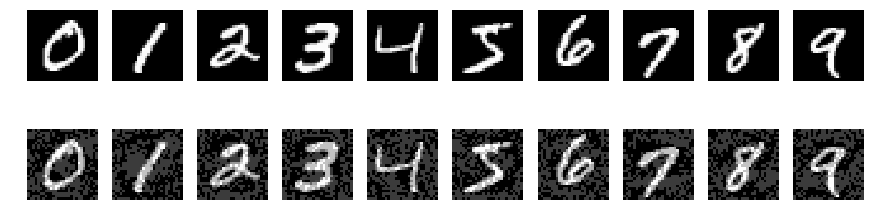

In [27]:
indices = [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]
plt.figure(figsize=[15,4])
n_digits = 10
for n in range(n_digits):
    idx = indices[n]
    plt.subplot(2,n_digits,n + 1)
    plt.imshow(np.reshape(train_in[idx], [28,28]), cmap='gray'); plt.axis('off');
    plt.subplot(2, n_digits, n + 1 + n_digits)
    plt.imshow(np.reshape(x_adv[idx], [28,28]), cmap='gray'); plt.axis('off');
    correct_label = np.argmax(y[idx])
    correct_score = y[idx][correct_label]
    wrong_label = np.argmax(y_adv[idx])
    wrong_score = y_adv[idx][wrong_label]
    print("digit " + str(correct_label) + " classified as " + str(wrong_label) + " with classificatiton value " + str(wrong_score) )

## (d) Targetted Adversarial Perturbation

In [28]:
num_x = train_out.shape[0]
train_out_adv = copy.deepcopy(train_out)
for i in range(num_x):
    if train_out_adv[i][5] == 1:
        train_out_adv[i][5] = 0
        train_out_adv[i][3] = 1
    elif train_out_adv[i][1] == 1:
        train_out_adv[i][1] = 0
        train_out_adv[i][8] = 1
    elif train_out_adv[i][7] == 1:
        train_out_adv[i][7] = 0
        train_out_adv[i][6] = 1
n = np.sum(train_out_adv, axis=0)
print(n)

[ 4932.     0.  4968.  9607.  4859.     0. 10126.     0. 10520.  4988.]


In [29]:
# ***** YOUR CODE HERE *****
net2 = NN.Network()
net2.Load('MNIST_trained_784-100-100-10.npy')
x2_adv = FGSM(net2, train_in, train_out_adv, targ=True, it_lim=4)


In [30]:
y2 = net.FeedForward(train_in)
t2 = np.argmax(y2, axis=1)

y2_adv = net.FeedForward(x2_adv)
t2_adv = np.argmax(y2_adv, axis=1)

perturbed 5 classified as 3 with classificatiton value 0.9984815564138496
perturbed 1 classified as 8 with classificatiton value 0.844886687083337
perturbed 7 classified as 4 with classificatiton value 0.9250143617357024


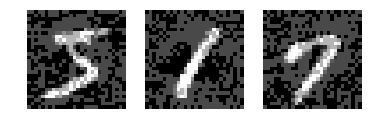

In [31]:
indices2 = [indices[5], indices[1], indices[7]]
n_digits = 3
for n in range(n_digits):
    idx = indices2[n]
    correct_label = np.argmax(y2[idx])
    correct_score = y2[idx][correct_label]
    wrong_label = np.argmax(y2_adv[idx])
    wrong_score = y2_adv[idx][wrong_label]
    plt.subplot(2,n_digits,n + 1)
    plt.imshow(np.reshape(x2_adv[idx], [28,28]), cmap='gray'); plt.axis('off');
    print("perturbed " + str(correct_label) + " classified as " + str(wrong_label) + " with classificatiton value " + str(wrong_score) )